# Loading Pre-Trained Models

In this tutorial, we'll use the `squeezenet` model to identify objects in images. The image location will pass in a URL to a photo or the location of a local file. The codes is a list of [AlexNet object codes](https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes), like "985" which equates to "daisy".

If you came from the Image Pre-Processing Tutorial, you will see that we're using rescale and crop functions to prep the image, as well as reformatting the image to be CHW, BGR, and finally NCHW. We also correct the image mean, by either using the calculated mean from a provided npy file or statically removing 128 as a placeholder average.

You'll find that loading pre-trained model is really simple and is accomplished in just a few lines of code. Here we show those few lines:

1. read the protobuf files

        with open("init_net.pb") as f:
            init_net = f.read()
        with open("predict_net.pb") as f:
            predict_net = f.read()        

2. use the Predictor function in your workspace to load the blobs from the protobufs

        p = workspace.Predictor(init_net, predict_net)

3. run the net and get the results!

        results = p.run([img])

The results come back as a multidimensional array of probabilities. Essentially each row is a percentage chance that the object matches something that the neural net recognizes. When you run the flower it should give you over 95% rating that the flower is a daisy.

## Configuration 

Settings are in a code block below. Most of the time these should run out of the box. 

### Model Download Options

Check out the [Model Zoo for pre-trained models](zoo), or you can also use Caffe2's `models.download` module to acquire pre-trained models from [Github caffe2/models](http://github.com/caffe2/models)
`caffe2.python.models.download` takes in an argument for the name of the model. Check the repo for the available models' names and swap out the `squeezenet` argument if you want to try something different. Example:

```
python -m caffe2.python.models.download -i squeezenet
```

If the above download worked then you should have a copy of squeezenet in your model folder or if you used the `-i` flag it will have installed the model locally in the `/caffe2/python/models` folder.
Alternatively, you can clone the entire repo of models: `git clone https://github.com/caffe2/models`.

In [1]:
%matplotlib inline
from caffe2.proto import caffe2_pb2
import numpy as np
import skimage.io
import skimage.transform
from matplotlib import pyplot
import os
from caffe2.python import core, workspace, models
import urllib2
print("Required modules imported.")

Required modules imported.


In [2]:
# Configuration --- Change to your setup and preferences!
CAFFE_MODELS = "/usr/local/caffe2/python/models"

# sample images you can try, or use any URL to a regular image.
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Whole-Lemon.jpg/1235px-Whole-Lemon.jpg"
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/7/7b/Orange-Whole-%26-Split.jpg"
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/a/ac/Pretzel.jpg"
# IMAGE_LOCATION = "https://cdn.pixabay.com/photo/2015/02/10/21/28/flower-631765_1280.jpg"
# IMAGE_LOCATION = "images/cat.jpg"
# IMAGE_LOCATION = "images/cowboy-hat.jpg"
# IMAGE_LOCATION = "images/cell-tower.jpg"
# IMAGE_LOCATION = "images/Ducreux.jpg"
# IMAGE_LOCATION = "images/pretzel.jpg"
# IMAGE_LOCATION = "images/orangutan.jpg"
# IMAGE_LOCATION = "images/aircraft-carrier.jpg"
IMAGE_LOCATION = "images/flower.jpg"

# What model are we using? You should have already converted or downloaded one.
# format below is the model's: 
# folder, INIT_NET, predict_net, mean, input image size
# you can switch squeezenet out with 'bvlc_alexnet', 'bvlc_googlenet' or others that you have downloaded
# if you have a mean file, place it in the same dir as the model
MODEL = 'squeezenet', 'init_net.pb', 'predict_net.pb', 'ilsvrc_2012_mean.npy', 227

# codes - these help decypher the output and source from a list from AlexNet's object codes to provide an result like "tabby cat" or "lemon" depending on what's in the picture you submit to the neural network.
# The list of output codes for the AlexNet models (squeezenet)
codes =  "https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes"
print "Config set!"

Config set!


In the block below we're loading the mean file (if it exists) and the image and then pre-processing the image for ingestion into a Caffe2 convolutional neural network!

Functions set.
mean was set to:  128
INIT_NET =  /usr/local/caffe2/python/models/squeezenet/init_net.pb
PREDICT_NET =  /usr/local/caffe2/python/models/squeezenet/predict_net.pb
/usr/local/caffe2/python/models/squeezenet/init_net.pb not found!
Original image shape:(751, 1280, 3) and remember it should be in H, W, C!
Model's input shape is 227x227
Orginal aspect ratio: 1.70439414115
New image shape:(227, 386, 3) in HWC
After crop:  (227, 227, 3)
NCHW:  (1, 3, 227, 227)


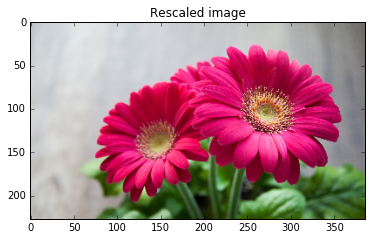

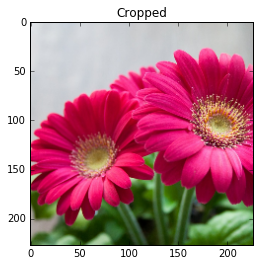

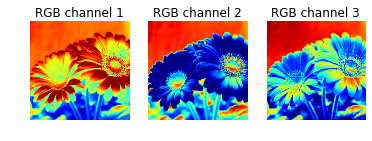

In [3]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def rescale(img, input_height, input_width):
    print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
    print("Model's input shape is %dx%d") % (input_height, input_width)
    aspect = img.shape[1]/float(img.shape[0])
    print("Orginal aspect ratio: " + str(aspect))
    if(aspect>1):
        # landscape orientation - wide image
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    if(aspect<1):
        # portrait orientation - tall image
        res = int(input_width/aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    if(aspect == 1):
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    pyplot.figure()
    pyplot.imshow(imgScaled)
    pyplot.axis('on')
    pyplot.title('Rescaled image')
    print("New image shape:" + str(imgScaled.shape) + " in HWC")
    return imgScaled
print "Functions set."

# set paths and variables from model choice and prep image
CAFFE_MODELS = os.path.expanduser(CAFFE_MODELS)

# mean can be 128 or custom based on the model
# gives better results to remove the colors found in all of the training images
MEAN_FILE = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[3])
if not os.path.exists(MEAN_FILE):
    mean = 128
else:
    mean = np.load(MEAN_FILE).mean(1).mean(1)
    mean = mean[:, np.newaxis, np.newaxis]
print "mean was set to: ", mean

# some models were trained with different image sizes, this helps you calibrate your image
INPUT_IMAGE_SIZE = MODEL[4]

# make sure all of the files are around...
#if not os.path.exists(CAFFE2_ROOT):
#    print("Houston, you may have a problem.") 
INIT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[1])
print 'INIT_NET = ', INIT_NET
PREDICT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[2])
print 'PREDICT_NET = ', PREDICT_NET
if not os.path.exists(INIT_NET):
    print(INIT_NET + " not found!")
else:
    print "Found ", INIT_NET, "...Now looking for", PREDICT_NET
    if not os.path.exists(PREDICT_NET):
        print "Caffe model file, " + PREDICT_NET + " was not found!"
    else:
        print "All needed files found! Loading the model in the next block."
        
# load and transform image
img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)
img = rescale(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
img = crop_center(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print "After crop: " , img.shape
pyplot.figure()
pyplot.imshow(img)
pyplot.axis('on')
pyplot.title('Cropped')

# switch to CHW
img = img.swapaxes(1, 2).swapaxes(0, 1)
pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(img[i])
    pyplot.axis('off')
    pyplot.title('RGB channel %d' % (i+1))

# switch to BGR
img = img[(2, 1, 0), :, :]

# remove mean for better results
img = img * 255 - mean

# add batch size
img = img[np.newaxis, :, :, :].astype(np.float32)
print "NCHW: ", img.shape

Now that the image is ready to be ingested by the CNN, let's open the protobufs, load them into the workspace, and run the net. 


In [4]:
# initialize the neural net

with open(INIT_NET) as f:
    init_net = f.read()
with open(PREDICT_NET) as f:
    predict_net = f.read()
    
p = workspace.Predictor(init_net, predict_net)

# run the net and return prediction
results = p.run([img])

# turn it into something we can play with and examine which is in a multi-dimensional array
results = np.asarray(results)
print "results shape: ", results.shape

IOError: [Errno 2] No such file or directory: '/usr/local/caffe2/python/models/squeezenet/init_net.pb'

See that we have 1000 result there in the middle? If we had submitted more that one image in our batch then the array would be larger, but still have 1000 units there in the middle. It is holding the probability for each category in the pre-trained model. So when you look at the results, it's like saying, "Computer, what's the probability that this is a Beryllium sphere?" Or gila monster, or any of the other 998 groups of things in there.

Let's see what you have! Run the next block for the result.

In [5]:
# the rest of this is digging through the results 
results = np.delete(results, 1)
index = 0
highest = 0
arr = np.empty((0,2), dtype=object)
arr[:,0] = int(10)
arr[:,1:] = float(10)
for i, r in enumerate(results):
    # imagenet index begins with 1!
    i=i+1
    arr = np.append(arr, np.array([[i,r]]), axis=0)
    if (r > highest):
        highest = r
        index = i 

# top 3 results
print "Raw top 3 results:", sorted(arr, key=lambda x: x[1], reverse=True)[:3]

# now we can grab the code list
response = urllib2.urlopen(codes)

# and lookup our result from the list
for line in response:
    code, result = line.partition(":")[::2]
    if (code.strip() == str(index)):
        print MODEL[0], "infers that the image contains ", result.strip()[1:-2], "with a ", highest*100, "% probability" 

NameError: name 'results' is not defined

##### Now that you've run it, try out some different images. See how well it does across more complicated images or with multiple objects or subjects. Several different objects are available in the 2nd (configuration) code block.